**Universidade Federal de Campina Grande**
<br/>
**Programa de Pós-Graduação em Ciência da Computação**
<br/>
**Disciplina:** _Aprendizagem de Máquina_
<br/>
**Estudante:** _Ruan Victor Bertoldo Reis de Amorim_

## <center>Classificação de Transformações Sintáticas em Técnicas de Síntese de Programas</center>

# 1. Introdução

<div style=\"text-align: justify\">
Em minha pesquisa de mestrado, eu estou desenvolvendo uma ferramenta interativa que fornece feedback de alto nível para alunos de introdução a programação. O objetivo da ferramenta, chamada de `TraceDiff`, é possibilitar que os estudantes entendam os comportamentos inesperados dos seus códigos comparando-os com versões corrigidas dos mesmos. Dentre as principais funcionalidades do `TraceDiff`, podemos destacar a capacidade de corrigir códigos Python em tempo real e de forma automatizada. Para esta tarefa, o `TraceDiff` utiliza uma técnica de síntese de programas chamada de `Refazer` que é capaz de aprender e aplicar transformações síntáticas de código.
<br/><br/>
Inicialmente, é necessário fornecer para o `Refazer` uma base de dados composta por conjuntos de códigos incorretos e suas respectivas correções. No seguinte exemplo, podemos observar uma possível entrada para nossa técnica de síntese de programas. O primeiro quadro representa um código incorreto, a linha em vermelho indica a localização do erro cometido na implementação. Em seguida, no segundo quadro, podemos observar uma versão corrigida, a linha em azul representa a edição que foi necessário para corrigir o referido código. Uma tupla contento estes dois códigos é dado como entrada para o `Refazer` para que ele aprenda transformações sintáticas que representem tal correção. Dessa forma, o `TraceDiff` pode aplicar essas tranformações sintáticas em submissões futuras de outros alunos.
![title](img/exemplo2.png) ![title](img/exemplo1.png)
<br/><br/>
Para uma única entrada ou exemplo, o `Refazer` pode aprender **centenas de transformações sintáticas** além da que é considerada correta. Isso acontece porque a técnica tenta obter o número máximo de variações de ambos os códigos. No entanto, algumas das transformações aprendidas estão muito distantes da transformação ideal, portanto, não é interessante mantê-las e nem aplicá-las. Neste trabalho de _Apredizagem de Máquina_, queremos implementar um classificador baseado em **regressão logística** que seja capaz de identificar transformações sintáticas indesejadas. Dessa forma, poderemos utilizar o classificador para eleminar as transformações de efeito negativo, assim, economizando os rescursos computacionais que são desperdiçados nesta operação.

</div>

# 2. Dados

<div style=\"text-align: justify\">
Os dados são compostos por 1314 transformações sintáticas geradas pelo `Refazer` a partir de edições executadas em três grandes projetos do Github (Roslyn, Entity Framework e NuGet). Dado o nosso conjunto de transformações, nós extraímos 12 features para conduzir este trabalho. Em seguida, a descrição de cada feature.
</div>
- **ConstNode:** _número de constantes no programa._
- **Reference:** _número de referências no programa._
- **_ConcretePattern:_**
- **_AbstractPattern:_**
- **Node:** _número de nós no programa._
- **Pattern:** _número de determinado padrão._
- **ParentOne:** _número de nós com apenas um pai._
- **ParentTwo:** _número de nós com dois pais._
- **ParentThree:** _número de nós com três pais._
- **NodeItself:** _número de nós sem pais._
- **SizeProg:** _número de linhas do programa._ 
- **NumberOp:** _número de operações utilizadas para gerar um programa._
- **Label:** _representa se uma transformação obteve efeito desejável(1) ou indesejável(0)._

In [54]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [27]:
data = pd.read_csv("data/ProgStatus.csv")

X = data[['ConstNode','Reference','ConcretePattern', 'AbstractPattern', 'Node', 'Pattern', 'ParentOne', 'ParentTwo', 'ParentThree', 'NodeItself', 'SizeProg', 'NumberOp']]
Y = data[['Label']].values.ravel()

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, train_size=0.9)

## 2. Model Evaluation Using Cross-Validation

In [28]:
c_values = [0.001, 0.005, 0.01, 0.05, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### 2.1 Log Loss Function

In [29]:
def scoring_loss_cv(model):
    scores_loss= -cross_val_score(model, X_TRAIN, Y_TRAIN, scoring="neg_log_loss", cv = 10)
    return(scores_loss)

In [30]:
cv_logistic_loss = [scoring_loss_cv(LogisticRegression(C = c)).mean() 
            for c in c_values]

Text(0,0.5,'Log Loss')

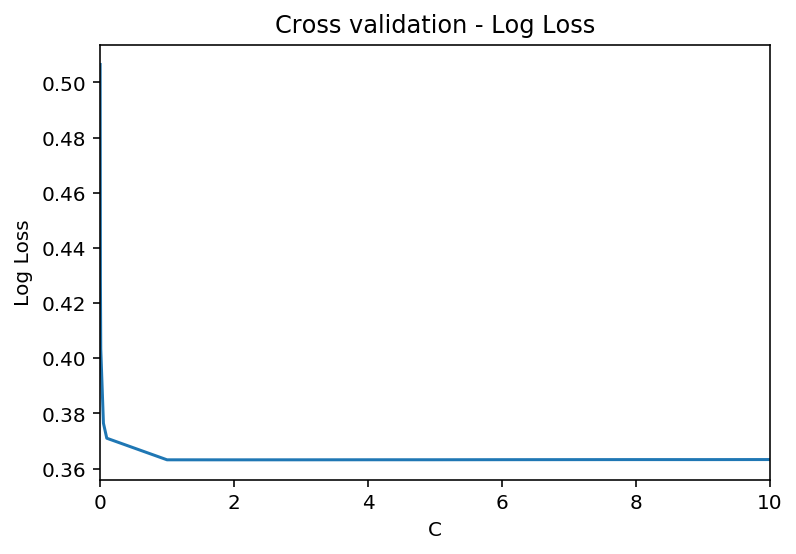

In [31]:
cv_logistic_loss = pd.Series(cv_logistic_loss, index = c_values)
cv_logistic_loss.plot(title = "Cross validation - Log Loss")
plt.xlabel("C")
plt.ylabel("Log Loss")

In [32]:
cv_logistic_loss

0.001     0.506509
0.005     0.428417
0.010     0.403389
0.050     0.376484
0.100     0.371035
1.000     0.363208
2.000     0.363201
3.000     0.363210
4.000     0.363226
5.000     0.363231
6.000     0.363256
7.000     0.363271
8.000     0.363286
9.000     0.363282
10.000    0.363303
dtype: float64

In [33]:
cv_logistic_loss.min()

0.3632005962099033

**C:** 2

In [35]:
logreg_loss = LogisticRegression(C=2)
model_loss = logreg_loss.fit(X_TRAIN, Y_TRAIN)
print (model_loss.coef_)

[[ 1.01891832 -0.97769788  0.86814416  1.12041877  0.35213978  0.41154074
   1.13726146  1.4259011   0.         -0.18259673 -0.28306168  0.28700776]]


In [36]:
model_loss.score(X_TRAIN, Y_TRAIN)

0.87055837563451777

### 2.2 Accuracy

In [37]:
def scoring_accuracy_cv(model):
    scores_accuracy= cross_val_score(model, X_TRAIN, Y_TRAIN, scoring="accuracy", cv = 10)
    return(scores_accuracy)

In [38]:
cv_logistic_accuracy = [scoring_accuracy_cv(LogisticRegression(C = c)).mean() 
            for c in c_values]

Text(0,0.5,'Accuracy')

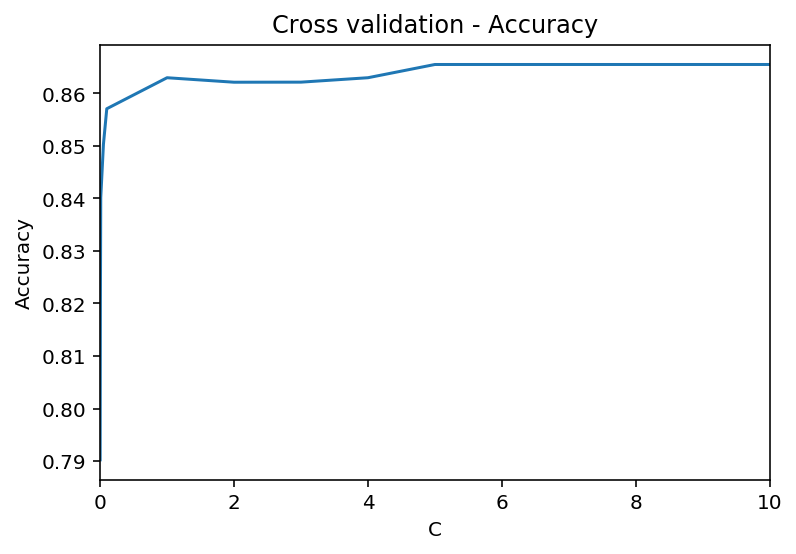

In [39]:
cv_logistic_accuracy = pd.Series(cv_logistic_accuracy, index = c_values)
cv_logistic_accuracy.plot(title = "Cross validation - Accuracy")
plt.xlabel("C")
plt.ylabel("Accuracy")

In [40]:
cv_logistic_accuracy

0.001     0.790235
0.005     0.820709
0.010     0.840173
0.050     0.850300
0.100     0.857073
1.000     0.862977
2.000     0.862122
3.000     0.862137
4.000     0.862977
5.000     0.865498
6.000     0.865498
7.000     0.865498
8.000     0.865498
9.000     0.865498
10.000    0.865498
dtype: float64

In [43]:
cv_logistic_accuracy.max()

0.86549801146012517

**C:** 10

In [45]:
logreg_accuracy = LogisticRegression(C=10)
model_accuracy = logreg_accuracy.fit(X_TRAIN, Y_TRAIN)
print (model_accuracy.coef_)

[[ 1.05245875 -0.93891213  0.95771349  1.20498944  0.4194467   0.4789257
   1.16437465  1.4705705   0.         -0.17894302 -0.32023679  0.40162507]]


In [46]:
model_accuracy.score(X_TRAIN, Y_TRAIN)

0.86886632825719123

### 2.3 Tuning the hyper-parameters with GridSearchCV

In [48]:
tuned_parameters = {'C': c_values }
model_grid_search = GridSearchCV(LogisticRegression(), tuned_parameters, cv=10)
model_grid_search.fit(X_TRAIN, Y_TRAIN)

model_grid_search.best_estimator_

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
model_grid_search.best_estimator_.coef_

array([[ 1.04389749, -0.94938499,  0.93312018,  1.18172893,  0.40092106,
         0.46057872,  1.15674575,  1.45835036,  0.        , -0.17984767,
        -0.31008578,  0.3704098 ]])

In [50]:
model_grid_search.score(X_TRAIN, Y_TRAIN)

0.86886632825719123

## 3.0 TEST

In [51]:
model_loss.score(X_TEST, Y_TEST)

0.8257575757575758

In [52]:
model_accuracy.score(X_TEST, Y_TEST)

0.8257575757575758

In [53]:
model_grid_search.score(X_TEST, Y_TEST)

0.8257575757575758